## Final Project - Reveal AI

In [ ]:
# from google.colab import files
# files.upload()
# !pip install timm
!pip install -U timm
# Path to the ZIP file on Google Drive (replace if your path is different)
from google.colab import drive
drive.mount('/content/drive')
DRIVE_ZIP_PATH = '/content/drive/MyDrive/data.zip'

# # Local temporary disk destination
LOCAL_DESTINATION = '/content/'

# # # Execute the copy command
!cp "{DRIVE_ZIP_PATH}" "{LOCAL_DESTINATION}"

print(f" Copied {DRIVE_ZIP_PATH} to local Colab disk.")
# # # Path to the ZIP file on the local disk
LOCAL_ZIP_PATH = '/content/data.zip'

# # # Execute the unzip command
# # # -q: quiet (less terminal output)
# # # -d /content/: extract contents to the /content/ directory
!unzip -q "{LOCAL_ZIP_PATH}" -d /content/

print(" Unzipping complete! Your data is now fast to access.")


Mounted at /content/drive
 Copied /content/drive/MyDrive/data.zip to local Colab disk.
 Unzipping complete! Your data is now fast to access.


In [ ]:
# imports
import os, sys,torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
import torch
import torch.nn.functional as F
import timm
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
# !unzip data.zip -d .

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
size_check = {}
# verify that the images are the same size or not
# print(os.listdir('1_fake')[0:10])
for img in os.listdir('/content/data/1_fake'):
    if '.ipynb_checkpoints' == img:
        continue
    images=Image.open('/content/data/1_fake/'+img)
    # print(images.size)
    if images.size in size_check:
        size_check[images.size] += 1
    else:
        size_check[images.size] = 1
print(list(size_check.items())[0:10])


[((450, 450), 743), ((450, 675), 1301), ((764, 1146), 1834), ((764, 1148), 29), ((764, 567), 19), ((764, 509), 361), ((512, 768), 275), ((764, 764), 377), ((1024, 1536), 295), ((1024, 1024), 108)]


In [ ]:
size_check = {}
# verify that the images are the same size or not
# print(os.listdir('1_fake')[0:10])
for img in os.listdir('/content/data/0_real'):
    if '.ipynb_checkpoints' == img:
        continue
    images=Image.open('/content/data/0_real/'+img)
    # print(images.size)
    if images.size in size_check:
        size_check[images.size] += 1
    else:
        size_check[images.size] = 1
print(list(size_check.items())[0:10])


[((500, 750), 3014), ((500, 357), 53), ((500, 321), 17), ((500, 331), 172), ((500, 625), 579), ((500, 333), 4795), ((500, 375), 719), ((500, 334), 572), ((500, 747), 33), ((500, 889), 175)]


In [ ]:
# Resize images for convnext
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Classes: {dataset.classes}")
print(f"Total images: {len(dataset)}")

Classes: ['0_real', '1_fake']
Total images: 26035


In [ ]:
model = timm.create_model('resnet50', pretrained=True, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Model ready on device:", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model ready on device: cuda


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
for epoch in range(5):
    total, correct, running_loss = 0, 0, 0
    model.train()
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss/len(dataloader):.4f}, Acc={acc:.2f}%")



Epoch 1: Loss=0.3590, Acc=86.68%
Epoch 2: Loss=0.1199, Acc=95.50%
Epoch 3: Loss=0.0553, Acc=98.17%
Epoch 4: Loss=0.0242, Acc=99.28%
Epoch 5: Loss=0.0109, Acc=99.77%


Predicted class: 0_real


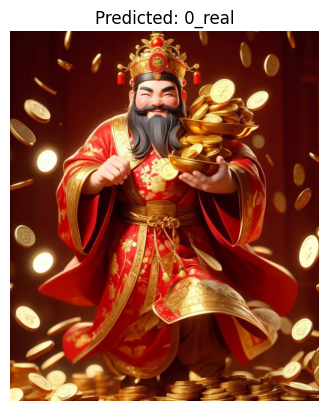

In [ ]:
# random image from fake set
img_path = '/content/data/1_fake/0ac485de-d5f7-4ee5-a620-354b6b766314.jpg'


tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = dataset.classes
print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()